# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters. It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PEST++GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin` folder. 

Preferably, executables should be located in a folder that is cited in your computer’s PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

Sometimes this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder:


In [2]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [3]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [4]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [5]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...


    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: C:\Program Files\MODFLOW\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 31 2021 14:57:11 with IFORT compiler (ver. 20.21.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 

    Solving:  Stress period:     2    Time step:     1
    Solving:  Stress period:     3    Time step:     1
    Solving:  Stress period:     4    Time step:     1
    Solving:  Stress period:     5    Time step:     1
    Solving:  Stress period:     6    Time step:     1
    Solving:  Stress period:     7    Time step:     1
    Solving:  Stress period:     8    Time step:     1
    Solving:  Stress period:     9    Time step:     1
    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    11    Time step:     1
    Solving:  Stress period:    12    Time step:     1
    Solving:  Stress period:    13    Time step:     1


    Solving:  Stress period:    14    Time step:     1
    Solving:  Stress period:    15    Time step:     1
    Solving:  Stress period:    16    Time step:     1
    Solving:  Stress period:    17    Time step:     1
    Solving:  Stress period:    18    Time step:     1
    Solving:  Stress period:    19    Time step:     1
    Solving:  Stress period:    20    Time step:     1
    Solving:  Stress period:    21    Time step:     1
    Solving:  Stress period:    22    Time step:     1
    Solving:  Stress period:    23    Time step:     1
    Solving:  Stress period:    24    Time step:     1
    Solving:  Stress period:    25    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/01 12:44:07
 Elapsed run time:  0.639 Seconds
 
 Normal termination of simulation.


(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [7]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-01 12:44:07.576757 starting: opening PstFrom.log for logging
2022-03-01 12:44:07.576757 starting PstFrom process
2022-03-01 12:44:07.577786 starting: setting up dirs
2022-03-01 12:44:07.577786 starting: removing existing new_d 'freyberg6_template'
2022-03-01 12:44:07.747495 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.169709


2022-03-01 12:44:08.761937 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'


2022-03-01 12:44:09.577189 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:00.815252
2022-03-01 12:44:09.577189 finished: setting up dirs took: 0:00:01.999403


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339320,34.581597,34.611207,34.872171,34.257574,34.136387,34.144465,34.027679,34.310857,34.171589,...,34.878082,34.263187,34.141599,34.150067,33.992380,34.316575,34.177206,33.909874,33.985755,33.890192
32.0,34.422684,34.680896,34.712058,34.973141,34.381609,34.245718,34.272721,34.138233,34.437640,34.313791,...,34.978998,34.386488,34.250497,34.277455,34.087585,34.442526,34.318135,33.992787,34.102892,34.005675
61.0,34.496186,34.778508,34.812111,35.083708,34.481942,34.330460,34.376598,34.219319,34.555036,34.427653,...,35.089608,34.487850,34.336217,34.382375,34.158109,34.560492,34.433115,34.058266,34.196067,34.086361
92.0,34.541607,34.848735,34.885189,35.178103,34.536194,34.372437,34.431944,34.257802,34.631805,34.490964,...,35.184255,34.543248,34.379139,34.438943,34.191730,34.638273,34.497733,34.090937,34.244095,34.121186
122.0,34.538213,34.859840,34.898354,35.214761,34.520171,34.353363,34.414553,34.236799,34.634051,34.476152,...,35.221267,34.528011,34.360599,34.422425,34.173799,34.641451,34.483960,34.076498,34.226023,34.095425


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [10]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [11]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-01 12:44:09.667369 starting: adding observations from output file heads.csv
2022-03-01 12:44:09.668367 starting: adding observations from tabular output file '['heads.csv']'
2022-03-01 12:44:09.668367 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-01 12:44:09.674870 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.006503
2022-03-01 12:44:09.674870 starting: building insfile for tabular output file heads.csv
2022-03-01 12:44:09.686871 finished: building insfile for tabular output file heads.csv took: 0:00:00.012001
2022-03-01 12:44:09.686871 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-01 12:44:09.704790 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.017919
2022-03-01 12:44:09.705787 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.037420


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [12]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.404445,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450289,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.449492,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.383839,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.332796,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [13]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [14]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.10,-477.76,1205.3
32.0,-865.29,-638.26,1636.6
61.0,-1034.00,-764.91,1938.5
92.0,-1118.70,-825.49,2073.6
122.0,-1083.00,-794.89,1983.4


In [15]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-01 12:44:09.762326 starting: adding observations from output file sfr.csv
2022-03-01 12:44:09.763323 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-01 12:44:09.763323 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-01 12:44:09.768310 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.004987
2022-03-01 12:44:09.768310 starting: building insfile for tabular output file sfr.csv


2022-03-01 12:44:09.775291 finished: building insfile for tabular output file sfr.csv took: 0:00:00.006981
2022-03-01 12:44:09.775291 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-01 12:44:09.787912 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.012621
2022-03-01 12:44:09.788909 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.025586


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

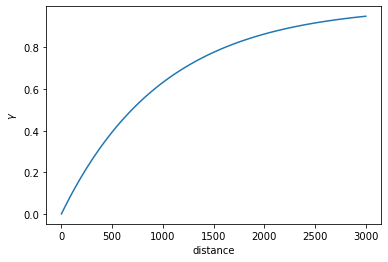

In [16]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [19]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-03-01 12:44:10.166217 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-01 12:44:10.166217 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-01 12:44:10.173199 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.006982
2022-03-01 12:44:10.173199 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-01 12:44:10.175193 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:10.175193 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-03-01 12:44:10.189189 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] took: 0:00:00.013996
2022-03-01 12:44:10.189189 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-0

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,scale,offset,dercom,parchglim
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1.0,0.0,1,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1.0,0.0,1,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1.0,0.0,1,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1.0,0.0,1,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1.0,0.0,1,factor


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [22]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-03-01 12:44:10.245954 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-01 12:44:10.246919 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-01 12:44:10.247951 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001032
2022-03-01 12:44:10.247951 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-01 12:44:10.248946 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:10.249943 starting: setting up pilot point parameters
2022-03-01 12:44:10.249943 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:10.249943 OK - using spatial reference in parent object.
2022-03-01 12:44:10.324973 32 pilot point parameters created
2022-03-01 12:44:10.324973 pilot point 'pargp':npf_k_layer1_pp
2022-03-01 12:44:10.324973 finished: setting up pilot point parameters took: 

2022-03-01 12:44:10.331954 saving krige variance file:freyberg6_template\npf_k_layer1_pp_inst0pp.var.dat
2022-03-01 12:44:10.331954 saving krige factors file:freyberg6_template\npf_k_layer1_pp_inst0pp.fac
starting interp point loop for 706 points


starting 0


starting 1


starting 2


starting 3


starting 4


starting 5


starting 6


starting 7


starting 8


starting 9


took 16.745617 seconds
2022-03-01 12:44:27.124463 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:16.793507
2022-03-01 12:44:27.124463 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2022-03-01 12:44:27.124463 saving zone array freyberg6_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl
2022-03-01 12:44:27.130431 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:16.884477


Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [23]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-03-01 12:44:27.156514 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-01 12:44:27.156514 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-01 12:44:27.159547 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.003033
2022-03-01 12:44:27.159547 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-01 12:44:27.162530 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:27.162530 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-03-01 12:44:27.171505 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0'] took: 0:00:00.008975
2022-03-01 12:44:27.171505 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_cn_inst0_cons

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [24]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [25]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-03-01 12:44:27.210334 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-01 12:44:27.211333 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-01 12:44:27.218317 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.006984
2022-03-01 12:44:27.218317 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-01 12:44:27.220275 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.220275 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-03-01 12:44:27.232582 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0'] took: 0:00:00.012307
2022-03-01 12:44:27.233582 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-0

2022-03-01 12:44:27.321380 32 pilot point parameters created
2022-03-01 12:44:27.321380 pilot point 'pargp':npf_k_layer2_pp
2022-03-01 12:44:27.322346 finished: setting up pilot point parameters took: 0:00:00.077761
2022-03-01 12:44:27.328328 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl'
2022-03-01 12:44:27.329327 saving zone array freyberg6_template\npf_k_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl


2022-03-01 12:44:27.366228 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt'] took: 0:00:00.125631
2022-03-01 12:44:27.366228 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-01 12:44:27.366228 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-01 12:44:27.368222 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.001994
2022-03-01 12:44:27.368222 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-01 12:44:27.370218 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:27.370218 starting: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_inst:0']
2022-03-01 12:44:27.378196 finished: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_ins

2022-03-01 12:44:27.411108 finished: writing template file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl for ['npf_k_layer3_gr_inst:0'] took: 0:00:00.012958
2022-03-01 12:44:27.411108 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.411108 saving zone array freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl
2022-03-01 12:44:27.418124 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.033944
2022-03-01 12:44:27.419122 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-01 12:44:27.419122 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-01 12:44:27.420082 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.000960
2022-03-01 12:44:27.420082 loaded array 'freyberg_mf6\freyberg6.np

2022-03-01 12:44:27.506851 saving zone array freyberg6_template\npf_k_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl
2022-03-01 12:44:27.512835 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.093713
2022-03-01 12:44:27.512835 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-01 12:44:27.512835 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-01 12:44:27.514883 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.002048
2022-03-01 12:44:27.514883 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-01 12:44:27.515879 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:27.515879 starting: writing template file freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl for ['npf_k_

Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [26]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-03-01 12:44:27.550768 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-01 12:44:27.550768 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt


2022-03-01 12:44:27.559763 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.008995
2022-03-01 12:44:27.559763 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-01 12:44:27.561757 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.561757 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-03-01 12:44:27.574726 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0'] took: 0:00:00.012969
2022-03-01 12:44:27.574726 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.574726 saving zone array freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl
2022-03-01 12:44:27.582681 finis

2022-03-01 12:44:27.666024 32 pilot point parameters created
2022-03-01 12:44:27.666024 pilot point 'pargp':npf_k33_layer1_pp
2022-03-01 12:44:27.666024 finished: setting up pilot point parameters took: 0:00:00.080351
2022-03-01 12:44:27.673058 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl'
2022-03-01 12:44:27.673058 saving zone array freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl
2022-03-01 12:44:27.679023 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt'] took: 0:00:00.096342
2022-03-01 12:44:27.679023 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-01 12:44:27.679023 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-01 12:44:27.681016 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.001993
2022

2022-03-01 12:44:27.702924 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.005952
2022-03-01 12:44:27.702924 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-01 12:44:27.705949 starting: writing array-style template file 'freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.705949 starting: writing template file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl for ['npf_k33_layer2_gr_inst:0']
2022-03-01 12:44:27.717884 finished: writing template file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl for ['npf_k33_layer2_gr_inst:0'] took: 0:00:00.011935
2022-03-01 12:44:27.717884 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.717884 saving zone array freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl
2022-03-01 12:44:27.725897 finis

2022-03-01 12:44:27.727892 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.001995
2022-03-01 12:44:27.727892 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-01 12:44:27.729892 starting: writing array-style template file 'freyberg6_template\npf_k33_layer2_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:27.729892 starting: setting up pilot point parameters
2022-03-01 12:44:27.729892 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:27.729892 OK - using spatial reference in parent object.


2022-03-01 12:44:27.817321 32 pilot point parameters created
2022-03-01 12:44:27.817321 pilot point 'pargp':npf_k33_layer2_pp
2022-03-01 12:44:27.817321 finished: setting up pilot point parameters took: 0:00:00.087429
2022-03-01 12:44:27.824288 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl'
2022-03-01 12:44:27.824288 saving zone array freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl
2022-03-01 12:44:27.830293 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.104396
2022-03-01 12:44:27.830293 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-01 12:44:27.830293 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-01 12:44:27.831289 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.000996
2022

2022-03-01 12:44:27.854178 finished: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt took: 0:00:00.005953
2022-03-01 12:44:27.854178 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer3.txt' of shape (40, 20)
2022-03-01 12:44:27.855226 starting: writing array-style template file 'freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.855226 starting: writing template file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0']
2022-03-01 12:44:27.868175 finished: writing template file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0'] took: 0:00:00.012949
2022-03-01 12:44:27.868175 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:27.868175 saving zone array freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl
2022-03-01 12:44:27.875153 finis

2022-03-01 12:44:27.950968 32 pilot point parameters created
2022-03-01 12:44:27.950968 pilot point 'pargp':npf_k33_layer3_pp
2022-03-01 12:44:27.950968 finished: setting up pilot point parameters took: 0:00:00.071805
2022-03-01 12:44:27.957931 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl'
2022-03-01 12:44:27.957931 saving zone array freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl
2022-03-01 12:44:27.963883 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt'] took: 0:00:00.087731
2022-03-01 12:44:27.963883 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt']
2022-03-01 12:44:27.963883 starting: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt
2022-03-01 12:44:27.964932 finished: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt took: 0:00:00.001049
2022

2022-03-01 12:44:28.011789 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.001993
2022-03-01 12:44:28.011789 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer2.txt' of shape (40, 20)
2022-03-01 12:44:28.013749 starting: writing array-style template file 'freyberg6_template\sto_ss_layer2_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:28.013749 starting: setting up pilot point parameters
2022-03-01 12:44:28.013749 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:28.013749 OK - using spatial reference in parent object.


2022-03-01 12:44:28.107473 32 pilot point parameters created
2022-03-01 12:44:28.107473 pilot point 'pargp':sto_ss_layer2_pp
2022-03-01 12:44:28.108503 finished: setting up pilot point parameters took: 0:00:00.094754
2022-03-01 12:44:28.115452 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl'
2022-03-01 12:44:28.115452 saving zone array freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2022-03-01 12:44:28.120475 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.110679
2022-03-01 12:44:28.121436 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-01 12:44:28.121436 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-01 12:44:28.122433 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.000997
2022-03-01 1

2022-03-01 12:44:28.132406 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:28.133404 saving zone array freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.zone for tpl file freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl
2022-03-01 12:44:28.139412 finished: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.017976
2022-03-01 12:44:28.139412 starting: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']
2022-03-01 12:44:28.139412 starting: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt
2022-03-01 12:44:28.145373 finished: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt took: 0:00:00.005961
2022-03-01 12:44:28.145373 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer3.txt' of shape (40, 20)
2022-03-01 12:44:28.148382 starting: writing array-style template file 'freyberg6_template\sto_ss_layer3_gr_inst0_

2022-03-01 12:44:28.265452 32 pilot point parameters created
2022-03-01 12:44:28.265452 pilot point 'pargp':sto_ss_layer3_pp
2022-03-01 12:44:28.265452 finished: setting up pilot point parameters took: 0:00:00.094149
2022-03-01 12:44:28.272434 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl'
2022-03-01 12:44:28.273432 saving zone array freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl
2022-03-01 12:44:28.289694 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.122329


2022-03-01 12:44:28.290656 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']
2022-03-01 12:44:28.290656 starting: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt
2022-03-01 12:44:28.293689 finished: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt took: 0:00:00.003033
2022-03-01 12:44:28.293689 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer3.txt' of shape (40, 20)
2022-03-01 12:44:28.296671 starting: writing array-style template file 'freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:28.296671 starting: writing template file freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl for ['sto_ss_layer3_cn_inst:0']
2022-03-01 12:44:28.314616 finished: writing template file freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl for ['sto_ss_layer3_cn_inst:0'] took: 0:00:00.017945
2022-03-01 12:44:28.314616 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_cn_

2022-03-01 12:44:28.329608 starting: adding grid type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-01 12:44:28.329608 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-01 12:44:28.336605 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.006997
2022-03-01 12:44:28.336605 loaded array 'freyberg_mf6\freyberg6.sto_sy_layer1.txt' of shape (40, 20)
2022-03-01 12:44:28.338586 starting: writing array-style template file 'freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:28.338586 starting: writing template file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl for ['sto_sy_layer1_gr_inst:0']
2022-03-01 12:44:28.351568 finished: writing template file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl for ['sto_sy_layer1_gr_inst:0'] took: 0:00:00.012982
2022-03-01 12:44:28.351568 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.t

2022-03-01 12:44:28.455375 finished: setting up pilot point parameters took: 0:00:00.092834
2022-03-01 12:44:28.462356 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl'
2022-03-01 12:44:28.462356 saving zone array freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl
2022-03-01 12:44:28.467342 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.108787
2022-03-01 12:44:28.467342 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-01 12:44:28.467342 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-01 12:44:28.469336 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.001994
2022-03-01 12:44:28.469336 loaded array 'freyberg_mf6\freyberg6.sto_sy_layer1.txt' of shape (40, 20)
2022-03-01 12:44:28.471297 starting:

2022-03-01 12:44:28.479308 saving zone array freyberg6_template\sto_sy_layer1_cn_inst0_constant.csv.zone for tpl file freyberg6_template\sto_sy_layer1_cn_inst0_constant.csv.tpl
2022-03-01 12:44:28.485293 finished: adding constant type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.017951


#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [27]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [28]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-03-01 12:44:28.536189 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-01 12:44:28.536189 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-01 12:44:28.542173 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.005984
2022-03-01 12:44:28.542173 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-01 12:44:28.545197 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:28.545197 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']
2022-03-01 12:44:28.558164 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0'] took: 0:00:00.012967
2022-03-01 12:44:28.558164 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_gr_inst0_

2022-03-01 12:44:28.645471 finished: setting up pilot point parameters took: 0:00:00.076335
2022-03-01 12:44:28.652484 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl'
2022-03-01 12:44:28.652484 saving zone array freyberg6_template\rch_recharge_1_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl
2022-03-01 12:44:28.657496 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.091354
2022-03-01 12:44:28.658492 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-01 12:44:28.658492 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-01 12:44:28.660431 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.001939
2022-03-01 12:44:28.660431 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-01 12:44:28.661480 s

2022-03-01 12:44:28.669457 finished: writing template file freyberg6_template\rch_recharge_1_cn_inst0_constant.csv.tpl for ['rch_recharge_1_cn_inst:0'] took: 0:00:00.007977
2022-03-01 12:44:28.669457 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:28.669457 saving zone array freyberg6_template\rch_recharge_1_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_1_cn_inst0_constant.csv.tpl
2022-03-01 12:44:28.675442 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.016950
2022-03-01 12:44:28.675442 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-01 12:44:28.675442 WARNING: 0) Inconsistency between geostruct transform and partrans.
2022-03-01 12:44:28.675442 WARNING: 1) Setting geostruct transform to {transform}
2022-03-01 12:44:28.675442 WARNING: -) Better to pass an appropriately tr

2022-03-01 12:44:28.723274 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-01 12:44:28.723274 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-01 12:44:28.725303 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.002029
2022-03-01 12:44:28.725303 loaded array 'freyberg_mf6\freyberg6.rch_recharge_10.txt' of shape (40, 20)
2022-03-01 12:44:28.727289 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:28.727289 starting: setting up pilot point parameters
2022-03-01 12:44:28.727289 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:28.727289 OK - using spatial reference in parent object.
2022-03-01 12:44:28.825235 32 pilot point parameters created
2022-03-01 12:44:28.825235 pilot point 'pargp':rch_recharge_10_pp
2022-03-01 12:44:28.826214 finished: setting up pilot point

2022-03-01 12:44:28.833194 saving zone array freyberg6_template\rch_recharge_10_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl
2022-03-01 12:44:28.838147 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.114873
2022-03-01 12:44:28.838147 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-01 12:44:28.839183 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-01 12:44:28.840177 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.000994
2022-03-01 12:44:28.840177 loaded array 'freyberg_mf6\freyberg6.rch_recharge_10.txt' of shape (40, 20)
2022-03-01 12:44:28.842172 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:28.842172 starting: writing template file freyberg6_template\rch_recharge_10_cn_inst0_co

2022-03-01 12:44:28.850152 saving zone array freyberg6_template\rch_recharge_10_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_10_cn_inst0_constant.csv.tpl
2022-03-01 12:44:28.856134 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.017987
2022-03-01 12:44:28.856134 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-01 12:44:28.856134 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-01 12:44:28.858131 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.001997
2022-03-01 12:44:28.858131 loaded array 'freyberg_mf6\freyberg6.rch_recharge_10.txt' of shape (40, 20)
2022-03-01 12:44:28.860328 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:28.860328 starting: writing template file freyberg6_template\rch_recharge_10

2022-03-01 12:44:28.914019 saving zone array freyberg6_template\rch_recharge_11_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_11_gr_inst0_grid.csv.tpl
2022-03-01 12:44:28.920992 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.027906
2022-03-01 12:44:28.920992 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-01 12:44:28.920992 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-01 12:44:28.922973 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.001981
2022-03-01 12:44:28.922973 loaded array 'freyberg_mf6\freyberg6.rch_recharge_11.txt' of shape (40, 20)
2022-03-01 12:44:28.924988 starting: writing array-style template file 'freyberg6_template\rch_recharge_11_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:28.924988 starting: setting up pilot point parameters
2022-03-01 12:44:28.924988 No

2022-03-01 12:44:29.028390 finished: writing template file freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl for ['rch_recharge_11_cn_inst:0'] took: 0:00:00.007952
2022-03-01 12:44:29.028390 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:29.029363 saving zone array freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl
2022-03-01 12:44:29.035398 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.017951
2022-03-01 12:44:29.035398 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-01 12:44:29.035398 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-01 12:44:29.036343 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.000945
2022-03-01 12:44:29.03

2022-03-01 12:44:29.038339 starting: writing array-style template file 'freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:29.039358 starting: writing template file freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl for ['rch_recharge_11_tcn_inst:0']
2022-03-01 12:44:29.046350 finished: writing template file freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl for ['rch_recharge_11_tcn_inst:0'] took: 0:00:00.006992
2022-03-01 12:44:29.046350 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:29.047314 saving zone array freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_11_tcn_inst0_constant.csv.tpl
2022-03-01 12:44:29.054349 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.018951
2022-03-01 12:44:29.054349 starting: adding grid type m style paramete

2022-03-01 12:44:29.187058 32 pilot point parameters created
2022-03-01 12:44:29.187058 pilot point 'pargp':rch_recharge_12_pp
2022-03-01 12:44:29.187058 finished: setting up pilot point parameters took: 0:00:00.100817
2022-03-01 12:44:29.193990 starting: writing array-based template file 'freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl'
2022-03-01 12:44:29.194988 saving zone array freyberg6_template\rch_recharge_12_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl
2022-03-01 12:44:29.199973 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.116754
2022-03-01 12:44:29.199973 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-01 12:44:29.199973 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-01 12:44:29.201006 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00.001

2022-03-01 12:44:29.216984 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.017011
2022-03-01 12:44:29.216984 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-01 12:44:29.217927 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-01 12:44:29.218976 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00.001049
2022-03-01 12:44:29.218976 loaded array 'freyberg_mf6\freyberg6.rch_recharge_12.txt' of shape (40, 20)
2022-03-01 12:44:29.220970 starting: writing array-style template file 'freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:29.220970 starting: writing template file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl for ['rch_recharge_12_tcn_inst:0']
2022-03-01 12:44:29.228950 finished: writing template file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.t

2022-03-01 12:44:29.229894 saving zone array freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl
2022-03-01 12:44:29.235938 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.018954
2022-03-01 12:44:29.236927 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt']
2022-03-01 12:44:29.236927 starting: loading array freyberg6_template\freyberg6.rch_recharge_13.txt
2022-03-01 12:44:29.242911 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.005984
2022-03-01 12:44:29.242911 loaded array 'freyberg_mf6\freyberg6.rch_recharge_13.txt' of shape (40, 20)
2022-03-01 12:44:29.244906 starting: writing array-style template file 'freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:29.244906 starting: writing template file freyberg6_template\rch_recharge_13_gr_ins

2022-03-01 12:44:29.366790 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl'
2022-03-01 12:44:29.366790 saving zone array freyberg6_template\rch_recharge_13_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl
2022-03-01 12:44:29.371776 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt'] took: 0:00:00.085734
2022-03-01 12:44:29.372806 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt']
2022-03-01 12:44:29.372806 starting: loading array freyberg6_template\freyberg6.rch_recharge_13.txt
2022-03-01 12:44:29.373772 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.000966
2022-03-01 12:44:29.373772 loaded array 'freyberg_mf6\freyberg6.rch_recharge_13.txt' of shape (40, 20)
2022-03-01 12:44:29.375801 starting: writing array-style template file 'freyberg6_template\rch_recharge_13_cn_in

2022-03-01 12:44:29.401697 saving zone array freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl
2022-03-01 12:44:29.408678 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt'] took: 0:00:00.018949
2022-03-01 12:44:29.408678 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']
2022-03-01 12:44:29.408678 starting: loading array freyberg6_template\freyberg6.rch_recharge_14.txt
2022-03-01 12:44:29.414716 finished: loading array freyberg6_template\freyberg6.rch_recharge_14.txt took: 0:00:00.006038
2022-03-01 12:44:29.414716 loaded array 'freyberg_mf6\freyberg6.rch_recharge_14.txt' of shape (40, 20)


2022-03-01 12:44:29.416690 starting: writing array-style template file 'freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:29.416690 starting: writing template file freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl for ['rch_recharge_14_gr_inst:0']
2022-03-01 12:44:29.429663 finished: writing template file freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl for ['rch_recharge_14_gr_inst:0'] took: 0:00:00.012973
2022-03-01 12:44:29.429663 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:29.429663 saving zone array freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl
2022-03-01 12:44:29.436655 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.027977
2022-03-01 12:44:29.437656 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rc

2022-03-01 12:44:29.560747 finished: writing template file freyberg6_template\rch_recharge_14_tcn_inst0_constant.csv.tpl for ['rch_recharge_14_tcn_inst:0'] took: 0:00:00.008011
2022-03-01 12:44:29.560747 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:29.561713 saving zone array freyberg6_template\rch_recharge_14_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_14_tcn_inst0_constant.csv.tpl
2022-03-01 12:44:29.568726 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.019948
2022-03-01 12:44:29.568726 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-01 12:44:29.568726 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-01 12:44:29.574711 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.005985
2022-03-01 12:44:29.5

2022-03-01 12:44:29.598612 finished: writing template file freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl for ['rch_recharge_15_gr_inst:0'] took: 0:00:00.014958
2022-03-01 12:44:29.598612 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl'


2022-03-01 12:44:29.599612 saving zone array freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl
2022-03-01 12:44:29.607589 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.038863
2022-03-01 12:44:29.607589 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-01 12:44:29.607589 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-01 12:44:29.608810 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.001221
2022-03-01 12:44:29.608810 loaded array 'freyberg_mf6\freyberg6.rch_recharge_15.txt' of shape (40, 20)
2022-03-01 12:44:29.611804 starting: writing array-style template file 'freyberg6_template\rch_recharge_15_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:29.611804 starting: setting up pilot point parameters
2022-03-01 12:44:29.611804 No

2022-03-01 12:44:29.744450 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-01 12:44:29.744450 starting: loading array freyberg6_template\freyberg6.rch_recharge_16.txt
2022-03-01 12:44:29.749451 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.005001
2022-03-01 12:44:29.749451 loaded array 'freyberg_mf6\freyberg6.rch_recharge_16.txt' of shape (40, 20)
2022-03-01 12:44:29.751431 starting: writing array-style template file 'freyberg6_template\rch_recharge_16_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:29.751431 starting: writing template file freyberg6_template\rch_recharge_16_gr_inst0_grid.csv.tpl for ['rch_recharge_16_gr_inst:0']
2022-03-01 12:44:29.765394 finished: writing template file freyberg6_template\rch_recharge_16_gr_inst0_grid.csv.tpl for ['rch_recharge_16_gr_inst:0'] took: 0:00:00.013963
2022-03-01 12:44:29.765394 starting: writing array-based template file 'freyberg6_template\rch_recharge_16

2022-03-01 12:44:29.848173 32 pilot point parameters created
2022-03-01 12:44:29.848173 pilot point 'pargp':rch_recharge_16_pp
2022-03-01 12:44:29.848173 finished: setting up pilot point parameters took: 0:00:00.070812
2022-03-01 12:44:29.855154 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl'
2022-03-01 12:44:29.855154 saving zone array freyberg6_template\rch_recharge_16_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl
2022-03-01 12:44:29.861138 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.087765
2022-03-01 12:44:29.861138 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-01 12:44:29.861138 starting: loading array freyberg6_template\freyberg6.rch_recharge_16.txt
2022-03-01 12:44:29.862135 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.000

2022-03-01 12:44:29.928196 finished: loading array freyberg6_template\freyberg6.rch_recharge_17.txt took: 0:00:00.001056
2022-03-01 12:44:29.928196 loaded array 'freyberg_mf6\freyberg6.rch_recharge_17.txt' of shape (40, 20)
2022-03-01 12:44:29.930184 starting: writing array-style template file 'freyberg6_template\rch_recharge_17_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:29.930184 starting: setting up pilot point parameters
2022-03-01 12:44:29.930184 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:29.930184 OK - using spatial reference in parent object.
2022-03-01 12:44:30.001993 32 pilot point parameters created
2022-03-01 12:44:30.001993 pilot point 'pargp':rch_recharge_17_pp
2022-03-01 12:44:30.001993 finished: setting up pilot point parameters took: 0:00:00.071809
2022-03-01 12:44:30.008977 starting: writing array-based template file 'freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl'
2022-03-01 12:44:30.008977 saving zone array freyberg6_template\rc

2022-03-01 12:44:30.044326 finished: writing template file freyberg6_template\rch_recharge_17_tcn_inst0_constant.csv.tpl for ['rch_recharge_17_tcn_inst:0'] took: 0:00:00.008424
2022-03-01 12:44:30.045376 starting: writing array-based template file 'freyberg6_template\rch_recharge_17_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:30.045376 saving zone array freyberg6_template\rch_recharge_17_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_17_tcn_inst0_constant.csv.tpl
2022-03-01 12:44:30.053336 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt'] took: 0:00:00.021419
2022-03-01 12:44:30.053336 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-01 12:44:30.053336 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-01 12:44:30.059341 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.006005
2022-03-01 12:44:30.0

2022-03-01 12:44:30.155642 32 pilot point parameters created
2022-03-01 12:44:30.155642 pilot point 'pargp':rch_recharge_18_pp
2022-03-01 12:44:30.155642 finished: setting up pilot point parameters took: 0:00:00.070367
2022-03-01 12:44:30.162585 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl'
2022-03-01 12:44:30.162585 saving zone array freyberg6_template\rch_recharge_18_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl
2022-03-01 12:44:30.167604 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.086321
2022-03-01 12:44:30.167604 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-01 12:44:30.167604 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-01 12:44:30.169602 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.001

2022-03-01 12:44:30.236440 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.031915
2022-03-01 12:44:30.236440 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-01 12:44:30.236440 starting: loading array freyberg6_template\freyberg6.rch_recharge_19.txt
2022-03-01 12:44:30.237386 finished: loading array freyberg6_template\freyberg6.rch_recharge_19.txt took: 0:00:00.000946
2022-03-01 12:44:30.237386 loaded array 'freyberg_mf6\freyberg6.rch_recharge_19.txt' of shape (40, 20)
2022-03-01 12:44:30.240376 starting: writing array-style template file 'freyberg6_template\rch_recharge_19_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:30.240376 starting: setting up pilot point parameters
2022-03-01 12:44:30.240376 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:30.240376 OK - using spatial reference in parent object.
2022-03-01 12:44:30.331645 32 pilot point para

2022-03-01 12:44:30.332629 finished: setting up pilot point parameters took: 0:00:00.092253
2022-03-01 12:44:30.339578 starting: writing array-based template file 'freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl'
2022-03-01 12:44:30.339578 saving zone array freyberg6_template\rch_recharge_19_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl
2022-03-01 12:44:30.345593 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.109153
2022-03-01 12:44:30.345593 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-01 12:44:30.345593 starting: loading array freyberg6_template\freyberg6.rch_recharge_19.txt
2022-03-01 12:44:30.347608 finished: loading array freyberg6_template\freyberg6.rch_recharge_19.txt took: 0:00:00.002015
2022-03-01 12:44:30.347608 loaded array 'freyberg_mf6\freyberg6.rch_recharge_19.txt' of shape (40, 20)
2022-03-01 12:44:30.

2022-03-01 12:44:30.411437 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-01 12:44:30.411437 starting: loading array freyberg6_template\freyberg6.rch_recharge_2.txt
2022-03-01 12:44:30.412425 finished: loading array freyberg6_template\freyberg6.rch_recharge_2.txt took: 0:00:00.000988
2022-03-01 12:44:30.413379 loaded array 'freyberg_mf6\freyberg6.rch_recharge_2.txt' of shape (40, 20)
2022-03-01 12:44:30.414430 starting: writing array-style template file 'freyberg6_template\rch_recharge_2_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:30.415406 starting: setting up pilot point parameters
2022-03-01 12:44:30.415406 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:30.415406 OK - using spatial reference in parent object.
2022-03-01 12:44:30.484283 32 pilot point parameters created
2022-03-01 12:44:30.484283 pilot point 'pargp':rch_recharge_2_pp
2022-03-01 12:44:30.484283 finished: setting up pilot point param

2022-03-01 12:44:30.536173 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt'] took: 0:00:00.020941
2022-03-01 12:44:30.536173 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt']
2022-03-01 12:44:30.536173 starting: loading array freyberg6_template\freyberg6.rch_recharge_20.txt
2022-03-01 12:44:30.542128 finished: loading array freyberg6_template\freyberg6.rch_recharge_20.txt took: 0:00:00.005955
2022-03-01 12:44:30.542128 loaded array 'freyberg_mf6\freyberg6.rch_recharge_20.txt' of shape (40, 20)
2022-03-01 12:44:30.545120 starting: writing array-style template file 'freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:30.545120 starting: writing template file freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl for ['rch_recharge_20_gr_inst:0']
2022-03-01 12:44:30.557139 finished: writing template file freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl for ['rch_recharge

2022-03-01 12:44:30.637842 32 pilot point parameters created
2022-03-01 12:44:30.637842 pilot point 'pargp':rch_recharge_20_pp
2022-03-01 12:44:30.638871 finished: setting up pilot point parameters took: 0:00:00.069803
2022-03-01 12:44:30.644845 starting: writing array-based template file 'freyberg6_template\rch_recharge_20_pp_inst0pp.dat.tpl'
2022-03-01 12:44:30.645839 saving zone array freyberg6_template\rch_recharge_20_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_20_pp_inst0pp.dat.tpl
2022-03-01 12:44:30.650825 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt'] took: 0:00:00.085731
2022-03-01 12:44:30.650825 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt']
2022-03-01 12:44:30.650825 starting: loading array freyberg6_template\freyberg6.rch_recharge_20.txt
2022-03-01 12:44:30.651822 finished: loading array freyberg6_template\freyberg6.rch_recharge_20.txt took: 0:00:00.000

2022-03-01 12:44:30.795649 32 pilot point parameters created
2022-03-01 12:44:30.795649 pilot point 'pargp':rch_recharge_21_pp
2022-03-01 12:44:30.795649 finished: setting up pilot point parameters took: 0:00:00.075775
2022-03-01 12:44:30.802597 starting: writing array-based template file 'freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl'
2022-03-01 12:44:30.802597 saving zone array freyberg6_template\rch_recharge_21_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl
2022-03-01 12:44:30.807619 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.091738
2022-03-01 12:44:30.807619 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt']
2022-03-01 12:44:30.808582 starting: loading array freyberg6_template\freyberg6.rch_recharge_21.txt
2022-03-01 12:44:30.809613 finished: loading array freyberg6_template\freyberg6.rch_recharge_21.txt took: 0:00:00.001

2022-03-01 12:44:30.825570 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.017951
2022-03-01 12:44:30.826533 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt']
2022-03-01 12:44:30.826533 starting: loading array freyberg6_template\freyberg6.rch_recharge_21.txt
2022-03-01 12:44:30.827532 finished: loading array freyberg6_template\freyberg6.rch_recharge_21.txt took: 0:00:00.000999
2022-03-01 12:44:30.827532 loaded array 'freyberg_mf6\freyberg6.rch_recharge_21.txt' of shape (40, 20)
2022-03-01 12:44:30.829558 starting: writing array-style template file 'freyberg6_template\rch_recharge_21_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:30.830559 starting: writing template file freyberg6_template\rch_recharge_21_tcn_inst0_constant.csv.tpl for ['rch_recharge_21_tcn_inst:0']
2022-03-01 12:44:30.839526 finished: writing template file freyberg6_template\rch_recharge_21_tcn_inst0_constant.csv.t

2022-03-01 12:44:30.985182 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt'] took: 0:00:00.017951
2022-03-01 12:44:30.986180 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt']
2022-03-01 12:44:30.986180 starting: loading array freyberg6_template\freyberg6.rch_recharge_22.txt
2022-03-01 12:44:30.987143 finished: loading array freyberg6_template\freyberg6.rch_recharge_22.txt took: 0:00:00.000963
2022-03-01 12:44:30.987143 loaded array 'freyberg_mf6\freyberg6.rch_recharge_22.txt' of shape (40, 20)
2022-03-01 12:44:30.989189 starting: writing array-style template file 'freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:30.989189 starting: writing template file freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.tpl for ['rch_recharge_22_tcn_inst:0']
2022-03-01 12:44:30.997224 finished: writing template file freyberg6_template\rch_recharge_22_tcn_inst0_constant.csv.t

2022-03-01 12:44:31.011187 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.005984
2022-03-01 12:44:31.011187 loaded array 'freyberg_mf6\freyberg6.rch_recharge_23.txt' of shape (40, 20)
2022-03-01 12:44:31.013163 starting: writing array-style template file 'freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:31.013163 starting: writing template file freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.tpl for ['rch_recharge_23_gr_inst:0']
2022-03-01 12:44:31.026151 finished: writing template file freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.tpl for ['rch_recharge_23_gr_inst:0'] took: 0:00:00.012988
2022-03-01 12:44:31.026151 starting: writing array-based template file 'freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:31.026151 saving zone array freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.tpl
2022-03-01 12:44:31.03

2022-03-01 12:44:31.168376 starting: writing array-style template file 'freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:31.168376 starting: writing template file freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.tpl for ['rch_recharge_24_gr_inst:0']
2022-03-01 12:44:31.180346 finished: writing template file freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.tpl for ['rch_recharge_24_gr_inst:0'] took: 0:00:00.011970
2022-03-01 12:44:31.180346 starting: writing array-based template file 'freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:31.180346 saving zone array freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_24_gr_inst0_grid.csv.tpl
2022-03-01 12:44:31.187325 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt'] took: 0:00:00.027905
2022-03-01 12:44:31.188325 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rc

2022-03-01 12:44:31.281816 32 pilot point parameters created
2022-03-01 12:44:31.281816 pilot point 'pargp':rch_recharge_24_pp
2022-03-01 12:44:31.281816 finished: setting up pilot point parameters took: 0:00:00.090500
2022-03-01 12:44:31.288797 starting: writing array-based template file 'freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl'
2022-03-01 12:44:31.289795 saving zone array freyberg6_template\rch_recharge_24_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl
2022-03-01 12:44:31.294782 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt'] took: 0:00:00.106457
2022-03-01 12:44:31.294782 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt']
2022-03-01 12:44:31.295780 starting: loading array freyberg6_template\freyberg6.rch_recharge_24.txt
2022-03-01 12:44:31.296808 finished: loading array freyberg6_template\freyberg6.rch_recharge_24.txt took: 0:00:00.001

2022-03-01 12:44:31.362652 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt'] took: 0:00:00.029919
2022-03-01 12:44:31.362652 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt']
2022-03-01 12:44:31.362652 starting: loading array freyberg6_template\freyberg6.rch_recharge_25.txt
2022-03-01 12:44:31.363599 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.000947
2022-03-01 12:44:31.363599 loaded array 'freyberg_mf6\freyberg6.rch_recharge_25.txt' of shape (40, 20)
2022-03-01 12:44:31.365624 starting: writing array-style template file 'freyberg6_template\rch_recharge_25_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:31.366625 starting: setting up pilot point parameters
2022-03-01 12:44:31.366625 No spatial reference (containing cell spacing) passed.
2022-03-01 12:44:31.366625 OK - using spatial reference in parent object.
2022-03-01 12:44:31.434594 32 pilot point para

2022-03-01 12:44:31.458549 saving zone array freyberg6_template\rch_recharge_25_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_25_cn_inst0_constant.csv.tpl
2022-03-01 12:44:31.465519 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt'] took: 0:00:00.017933
2022-03-01 12:44:31.465519 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt']
2022-03-01 12:44:31.465519 starting: loading array freyberg6_template\freyberg6.rch_recharge_25.txt
2022-03-01 12:44:31.467513 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.001994
2022-03-01 12:44:31.467513 loaded array 'freyberg_mf6\freyberg6.rch_recharge_25.txt' of shape (40, 20)
2022-03-01 12:44:31.469511 starting: writing array-style template file 'freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:31.469511 starting: writing template file freyberg6_template\rch_recharge_25

2022-03-01 12:44:31.586481 32 pilot point parameters created
2022-03-01 12:44:31.586481 pilot point 'pargp':rch_recharge_3_pp
2022-03-01 12:44:31.586481 finished: setting up pilot point parameters took: 0:00:00.069792
2022-03-01 12:44:31.593709 starting: writing array-based template file 'freyberg6_template\rch_recharge_3_pp_inst0pp.dat.tpl'
2022-03-01 12:44:31.593709 saving zone array freyberg6_template\rch_recharge_3_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_3_pp_inst0pp.dat.tpl
2022-03-01 12:44:31.598744 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt'] took: 0:00:00.085101
2022-03-01 12:44:31.598744 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt']
2022-03-01 12:44:31.598744 starting: loading array freyberg6_template\freyberg6.rch_recharge_3.txt
2022-03-01 12:44:31.600742 finished: loading array freyberg6_template\freyberg6.rch_recharge_3.txt took: 0:00:00.001998
2022

2022-03-01 12:44:31.656571 saving zone array freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.tpl
2022-03-01 12:44:31.664548 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.028955
2022-03-01 12:44:31.664548 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-01 12:44:31.664548 starting: loading array freyberg6_template\freyberg6.rch_recharge_4.txt
2022-03-01 12:44:31.666511 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.001963
2022-03-01 12:44:31.666511 loaded array 'freyberg_mf6\freyberg6.rch_recharge_4.txt' of shape (40, 20)
2022-03-01 12:44:31.668558 starting: writing array-style template file 'freyberg6_template\rch_recharge_4_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:31.668558 starting: setting up pilot point parameters
2022-03-01 12:44:31.668558 No spatial

2022-03-01 12:44:31.771386 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.001052
2022-03-01 12:44:31.771386 loaded array 'freyberg_mf6\freyberg6.rch_recharge_4.txt' of shape (40, 20)
2022-03-01 12:44:31.773326 starting: writing array-style template file 'freyberg6_template\rch_recharge_4_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:31.774325 starting: writing template file freyberg6_template\rch_recharge_4_tcn_inst0_constant.csv.tpl for ['rch_recharge_4_tcn_inst:0']
2022-03-01 12:44:31.781306 finished: writing template file freyberg6_template\rch_recharge_4_tcn_inst0_constant.csv.tpl for ['rch_recharge_4_tcn_inst:0'] took: 0:00:00.006981
2022-03-01 12:44:31.781306 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:31.782340 saving zone array freyberg6_template\rch_recharge_4_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_4_tcn_inst0_constant.csv.tpl


2022-03-01 12:44:31.892474 32 pilot point parameters created
2022-03-01 12:44:31.892474 pilot point 'pargp':rch_recharge_5_pp
2022-03-01 12:44:31.892474 finished: setting up pilot point parameters took: 0:00:00.069830
2022-03-01 12:44:31.898706 starting: writing array-based template file 'freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl'
2022-03-01 12:44:31.899705 saving zone array freyberg6_template\rch_recharge_5_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl
2022-03-01 12:44:31.904690 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt'] took: 0:00:00.086018
2022-03-01 12:44:31.904690 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt']
2022-03-01 12:44:31.904690 starting: loading array freyberg6_template\freyberg6.rch_recharge_5.txt
2022-03-01 12:44:31.906685 finished: loading array freyberg6_template\freyberg6.rch_recharge_5.txt took: 0:00:00.001995
2022

2022-03-01 12:44:31.964445 saving zone array freyberg6_template\rch_recharge_6_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_6_gr_inst0_grid.csv.tpl
2022-03-01 12:44:31.971459 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt'] took: 0:00:00.028903
2022-03-01 12:44:31.971459 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt']
2022-03-01 12:44:31.971459 starting: loading array freyberg6_template\freyberg6.rch_recharge_6.txt
2022-03-01 12:44:31.973420 finished: loading array freyberg6_template\freyberg6.rch_recharge_6.txt took: 0:00:00.001961
2022-03-01 12:44:31.973420 loaded array 'freyberg_mf6\freyberg6.rch_recharge_6.txt' of shape (40, 20)
2022-03-01 12:44:31.975449 starting: writing array-style template file 'freyberg6_template\rch_recharge_6_pp_inst0_pilotpoints.csv.tpl'
2022-03-01 12:44:31.975449 starting: setting up pilot point parameters
2022-03-01 12:44:31.975449 No spatial

2022-03-01 12:44:32.070648 finished: loading array freyberg6_template\freyberg6.rch_recharge_6.txt took: 0:00:00.001995
2022-03-01 12:44:32.070648 loaded array 'freyberg_mf6\freyberg6.rch_recharge_6.txt' of shape (40, 20)
2022-03-01 12:44:32.072655 starting: writing array-style template file 'freyberg6_template\rch_recharge_6_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:32.072655 starting: writing template file freyberg6_template\rch_recharge_6_cn_inst0_constant.csv.tpl for ['rch_recharge_6_cn_inst:0']
2022-03-01 12:44:32.080622 finished: writing template file freyberg6_template\rch_recharge_6_cn_inst0_constant.csv.tpl for ['rch_recharge_6_cn_inst:0'] took: 0:00:00.007967
2022-03-01 12:44:32.080622 starting: writing array-based template file 'freyberg6_template\rch_recharge_6_cn_inst0_constant.csv.tpl'
2022-03-01 12:44:32.080622 saving zone array freyberg6_template\rch_recharge_6_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_6_cn_inst0_constant.csv.tpl
2022-03-

2022-03-01 12:44:32.217287 32 pilot point parameters created
2022-03-01 12:44:32.217287 pilot point 'pargp':rch_recharge_7_pp
2022-03-01 12:44:32.217287 finished: setting up pilot point parameters took: 0:00:00.075860
2022-03-01 12:44:32.224244 starting: writing array-based template file 'freyberg6_template\rch_recharge_7_pp_inst0pp.dat.tpl'
2022-03-01 12:44:32.224244 saving zone array freyberg6_template\rch_recharge_7_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_7_pp_inst0pp.dat.tpl
2022-03-01 12:44:32.230228 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt'] took: 0:00:00.092792
2022-03-01 12:44:32.231226 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt']
2022-03-01 12:44:32.231226 starting: loading array freyberg6_template\freyberg6.rch_recharge_7.txt
2022-03-01 12:44:32.232241 finished: loading array freyberg6_template\freyberg6.rch_recharge_7.txt took: 0:00:00.001015
2022

2022-03-01 12:44:32.269125 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt'] took: 0:00:00.019949
2022-03-01 12:44:32.269125 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-01 12:44:32.269125 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-01 12:44:32.275075 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.005950
2022-03-01 12:44:32.275075 loaded array 'freyberg_mf6\freyberg6.rch_recharge_8.txt' of shape (40, 20)
2022-03-01 12:44:32.277074 starting: writing array-style template file 'freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:32.278097 starting: writing template file freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl for ['rch_recharge_8_gr_inst:0']
2022-03-01 12:44:32.289088 finished: writing template file freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl for ['rch_recharge_8_gr_in

2022-03-01 12:44:32.401769 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.000980
2022-03-01 12:44:32.401769 loaded array 'freyberg_mf6\freyberg6.rch_recharge_8.txt' of shape (40, 20)
2022-03-01 12:44:32.404761 starting: writing array-style template file 'freyberg6_template\rch_recharge_8_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:32.404761 starting: writing template file freyberg6_template\rch_recharge_8_tcn_inst0_constant.csv.tpl for ['rch_recharge_8_tcn_inst:0']
2022-03-01 12:44:32.411761 finished: writing template file freyberg6_template\rch_recharge_8_tcn_inst0_constant.csv.tpl for ['rch_recharge_8_tcn_inst:0'] took: 0:00:00.007000
2022-03-01 12:44:32.411761 starting: writing array-based template file 'freyberg6_template\rch_recharge_8_tcn_inst0_constant.csv.tpl'
2022-03-01 12:44:32.412740 saving zone array freyberg6_template\rch_recharge_8_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_8_tcn_inst0_constant.csv.tpl


2022-03-01 12:44:32.524441 32 pilot point parameters created
2022-03-01 12:44:32.525405 pilot point 'pargp':rch_recharge_9_pp
2022-03-01 12:44:32.525405 finished: setting up pilot point parameters took: 0:00:00.072752
2022-03-01 12:44:32.532441 starting: writing array-based template file 'freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl'
2022-03-01 12:44:32.532441 saving zone array freyberg6_template\rch_recharge_9_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl
2022-03-01 12:44:32.537426 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt'] took: 0:00:00.087766
2022-03-01 12:44:32.537426 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt']
2022-03-01 12:44:32.537426 starting: loading array freyberg6_template\freyberg6.rch_recharge_9.txt
2022-03-01 12:44:32.539368 finished: loading array freyberg6_template\freyberg6.rch_recharge_9.txt took: 0:00:00.001942
2022

### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

2022-03-01 12:44:32.615186 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-01 12:44:32.615186 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-01 12:44:32.616224 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-01 12:44:32.618174 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.001950
2022-03-01 12:44:32.618174 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-01 12:44:32.619170 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.003984
2022-03-01 12:44:32.619170 starting: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:32.624188 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are

2022-03-01 12:44:32.716944 finished: writing list-style template file 'freyberg6_template\ghbhead_cn_inst0_constant.csv.tpl' took: 0:00:00.013945
2022-03-01 12:44:32.722926 finished: adding constant type a style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt'] took: 0:00:00.022932


Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [31]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-03-01 12:44:32.756186 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-01 12:44:32.756186 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-01 12:44:32.756186 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-01 12:44:32.759184 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.002998
2022-03-01 12:44:32.760426 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-01 12:44:32.761139 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.004953
2022-03-01 12:44:32.761139 starting: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl'


2022-03-01 12:44:32.774129 finished: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl' took: 0:00:00.012990
2022-03-01 12:44:32.783108 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt'] took: 0:00:00.026922
2022-03-01 12:44:32.783108 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-01 12:44:32.783108 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-01 12:44:32.783108 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-01 12:44:32.785102 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001994
2022-03-01 12:44:32.785102 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-01 12:44:32.786072 finished: loading list-style freyberg6_template\freyb

2022-03-01 12:44:32.807016 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt'] took: 0:00:00.023908
2022-03-01 12:44:32.807016 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2022-03-01 12:44:32.807016 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-01 12:44:32.807016 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-01 12:44:32.810009 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.002993
2022-03-01 12:44:32.811005 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_10.txt' of shape (6, 4)
2022-03-01 12:44:32.812003 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.004987
2022-03-01 12:44:32.812003 starting: writing list-style template file 'freyberg6_t

2022-03-01 12:44:32.901763 finished: writing list-style template file 'freyberg6_template\wel_grd_inst2_grid.csv.tpl' took: 0:00:00.013899
2022-03-01 12:44:32.909741 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.025930
2022-03-01 12:44:32.909741 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-01 12:44:32.909741 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-01 12:44:32.910739 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-01 12:44:32.912777 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.002038
2022-03-01 12:44:32.912777 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-01 12:44:32.913731 finished: loading list-style freyberg6_template\fre

2022-03-01 12:44:32.960764 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-01 12:44:32.960764 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-01 12:44:32.961767 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-01 12:44:32.963724 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.001957
2022-03-01 12:44:32.963724 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-01 12:44:32.964759 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.003995
2022-03-01 12:44:32.964759 starting: writing list-style template file 'freyberg6_template\wel_cst_inst4_constant.csv.tpl'
2022-03-01 12:44:32.978737 finished: writing list-style template file 'freyberg6_template\wel_cst_inst4_const

2022-03-01 12:44:32.989686 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.003970
2022-03-01 12:44:32.989686 starting: writing list-style template file 'freyberg6_template\wel_grd_inst4_grid.csv.tpl'
2022-03-01 12:44:33.002268 finished: writing list-style template file 'freyberg6_template\wel_grd_inst4_grid.csv.tpl' took: 0:00:00.012582
2022-03-01 12:44:33.011225 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt'] took: 0:00:00.025509
2022-03-01 12:44:33.011225 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt']
2022-03-01 12:44:33.011225 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-01 12:44:33.012255 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-01 12:44:33.014268 finished: reading list-style file: freyberg6_template\freyber

2022-03-01 12:44:33.087307 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt']
2022-03-01 12:44:33.087307 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-01 12:44:33.088304 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-01 12:44:33.089269 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt took: 0:00:00.000965
2022-03-01 12:44:33.089269 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_15.txt' of shape (6, 4)
2022-03-01 12:44:33.090299 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_15.txt took: 0:00:00.002992
2022-03-01 12:44:33.091264 starting: writing list-style template file 'freyberg6_template\wel_grd_inst6_grid.csv.tpl'
2022-03-01 12:44:33.105254 finished: writing list-style template file 'freyberg6_template\wel_grd_inst6_grid.csv.tpl'

2022-03-01 12:44:33.155922 finished: writing list-style template file 'freyberg6_template\wel_grd_inst7_grid.csv.tpl' took: 0:00:00.013963
2022-03-01 12:44:33.164903 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt'] took: 0:00:00.025933
2022-03-01 12:44:33.164903 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-01 12:44:33.164903 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-01 12:44:33.164903 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-01 12:44:33.166910 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.002007
2022-03-01 12:44:33.166910 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-01 12:44:33.168958 finished: loading list-style freyberg6_template\fre

2022-03-01 12:44:33.193895 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt'] took: 0:00:00.028992
2022-03-01 12:44:33.193895 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-01 12:44:33.193895 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-01 12:44:33.193895 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-01 12:44:33.195923 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.002028
2022-03-01 12:44:33.195923 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-01 12:44:33.196940 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.003045
2022-03-01 12:44:33.196940 starting: writing list-style template file 'freyberg6_

2022-03-01 12:44:33.275676 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-01 12:44:33.278667 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.002991
2022-03-01 12:44:33.278667 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_19.txt' of shape (6, 4)
2022-03-01 12:44:33.279664 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.004986
2022-03-01 12:44:33.279664 starting: writing list-style template file 'freyberg6_template\wel_cst_inst10_constant.csv.tpl'
2022-03-01 12:44:33.292631 finished: writing list-style template file 'freyberg6_template\wel_cst_inst10_constant.csv.tpl' took: 0:00:00.012967
2022-03-01 12:44:33.301606 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt'] took: 0:00:00.026928
2022-03-01 12:44:33.301606 starting: adding grid type m st

2022-03-01 12:44:33.354485 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt'] took: 0:00:00.025917
2022-03-01 12:44:33.354485 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-01 12:44:33.354485 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-01 12:44:33.354485 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-01 12:44:33.356493 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.002008
2022-03-01 12:44:33.356493 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-01 12:44:33.357490 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.003005
2022-03-01 12:44:33.357490 starting: writing list-style template file 'freyberg6_templat

2022-03-01 12:44:33.380449 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt']
2022-03-01 12:44:33.380449 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-01 12:44:33.381425 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-01 12:44:33.383389 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.001964
2022-03-01 12:44:33.383389 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2022-03-01 12:44:33.384441 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.003992
2022-03-01 12:44:33.385381 starting: writing list-style template file 'freyberg6_template\wel_cst_inst12_constant.csv.tpl'
2022-03-01 12:44:33.398752 finished: writing list-style template file 'freyberg6_template\wel_cst_inst12_con

2022-03-01 12:44:33.458614 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-01 12:44:33.460560 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.001946
2022-03-01 12:44:33.460560 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_21.txt' of shape (6, 4)
2022-03-01 12:44:33.461608 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.002994
2022-03-01 12:44:33.462555 starting: writing list-style template file 'freyberg6_template\wel_grd_inst13_grid.csv.tpl'
2022-03-01 12:44:33.475546 finished: writing list-style template file 'freyberg6_template\wel_grd_inst13_grid.csv.tpl' took: 0:00:00.012991
2022-03-01 12:44:33.483499 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt'] took: 0:00:00.024885
2022-03-01 12:44:33.484541 starting: adding constant type m style para

2022-03-01 12:44:33.536728 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-01 12:44:33.538720 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.001992
2022-03-01 12:44:33.538720 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_23.txt' of shape (6, 4)
2022-03-01 12:44:33.539704 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.003977
2022-03-01 12:44:33.539704 starting: writing list-style template file 'freyberg6_template\wel_cst_inst15_constant.csv.tpl'
2022-03-01 12:44:33.553142 finished: writing list-style template file 'freyberg6_template\wel_cst_inst15_constant.csv.tpl' took: 0:00:00.013438
2022-03-01 12:44:33.562151 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt'] took: 0:00:00.026424
2022-03-01 12:44:33.562151 starting: adding grid type m st

2022-03-01 12:44:33.587093 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt'] took: 0:00:00.024942
2022-03-01 12:44:33.588083 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt']
2022-03-01 12:44:33.588083 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-01 12:44:33.588083 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-01 12:44:33.590043 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.001960
2022-03-01 12:44:33.590043 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_24.txt' of shape (6, 4)
2022-03-01 12:44:33.591089 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.003006
2022-03-01 12:44:33.591089 starting: writing list-style template file 'freyberg6_

2022-03-01 12:44:33.657278 finished: writing list-style template file 'freyberg6_template\wel_cst_inst17_constant.csv.tpl' took: 0:00:00.013996
2022-03-01 12:44:33.666253 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_25.txt'] took: 0:00:00.026960
2022-03-01 12:44:33.666253 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_25.txt']
2022-03-01 12:44:33.666253 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_25.txt
2022-03-01 12:44:33.666253 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt
2022-03-01 12:44:33.668215 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt took: 0:00:00.001962
2022-03-01 12:44:33.668215 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_25.txt' of shape (6, 4)
2022-03-01 12:44:33.669265 finished: loading list-style freyberg6_templat

2022-03-01 12:44:33.734073 finished: writing list-style template file 'freyberg6_template\wel_grd_inst18_grid.csv.tpl' took: 0:00:00.013996
2022-03-01 12:44:33.743015 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt'] took: 0:00:00.025884
2022-03-01 12:44:33.743015 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-01 12:44:33.743015 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-01 12:44:33.744012 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-01 12:44:33.746060 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.002048
2022-03-01 12:44:33.746060 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-01 12:44:33.747005 finished: loading list-style freyberg6_template\freyberg

2022-03-01 12:44:33.769968 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-01 12:44:33.770988 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.001020
2022-03-01 12:44:33.770988 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-01 12:44:33.771971 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.002981
2022-03-01 12:44:33.771971 starting: writing list-style template file 'freyberg6_template\wel_grd_inst19_grid.csv.tpl'
2022-03-01 12:44:33.786843 finished: writing list-style template file 'freyberg6_template\wel_grd_inst19_grid.csv.tpl' took: 0:00:00.014872
2022-03-01 12:44:33.794876 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.025886
2022-03-01 12:44:33.795859 starting: adding constant type m style parameter

2022-03-01 12:44:33.837284 finished: writing list-style template file 'freyberg6_template\wel_grd_inst20_grid.csv.tpl' took: 0:00:00.012966
2022-03-01 12:44:33.846313 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_5.txt'] took: 0:00:00.025933
2022-03-01 12:44:33.847290 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_6.txt']
2022-03-01 12:44:33.847290 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-01 12:44:33.847290 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-01 12:44:33.849304 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.002014
2022-03-01 12:44:33.849304 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_6.txt' of shape (6, 4)
2022-03-01 12:44:33.850301 finished: loading list-style freyberg6_template\freyberg

2022-03-01 12:44:33.915110 finished: writing list-style template file 'freyberg6_template\wel_cst_inst22_constant.csv.tpl' took: 0:00:00.013931
2022-03-01 12:44:33.923106 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt'] took: 0:00:00.024927
2022-03-01 12:44:33.924104 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt']
2022-03-01 12:44:33.924104 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_7.txt
2022-03-01 12:44:33.924104 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt
2022-03-01 12:44:33.925083 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.000979
2022-03-01 12:44:33.926102 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_7.txt' of shape (6, 4)
2022-03-01 12:44:33.927046 finished: loading list-style freyberg6_template\frey

2022-03-01 12:44:33.968932 finished: writing list-style template file 'freyberg6_template\wel_cst_inst23_constant.csv.tpl' took: 0:00:00.013928
2022-03-01 12:44:33.977028 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt'] took: 0:00:00.027990
2022-03-01 12:44:33.977909 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt']
2022-03-01 12:44:33.977909 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-01 12:44:33.977909 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-01 12:44:33.979955 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt took: 0:00:00.002046
2022-03-01 12:44:33.979955 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_8.txt' of shape (6, 4)
2022-03-01 12:44:33.980952 finished: loading list-style freyberg6_template\frey

2022-03-01 12:44:34.028861 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt'] took: 0:00:00.025890
2022-03-01 12:44:34.028861 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt']
2022-03-01 12:44:34.029858 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-01 12:44:34.029858 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-01 12:44:34.031855 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.001997
2022-03-01 12:44:34.031855 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_9.txt' of shape (6, 4)
2022-03-01 12:44:34.031855 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.001997
2022-03-01 12:44:34.032850 starting: writing list-style template file 'freyberg6_templat

And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [32]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-03-01 12:44:34.082069 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-01 12:44:34.082069 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-01 12:44:34.082069 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-01 12:44:34.085061 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.002992
2022-03-01 12:44:34.085061 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-01 12:44:34.086041 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.003972
2022-03-01 12:44:34.086041 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:34.091047 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries 

2022-03-01 12:44:34.105985 finished: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl' took: 0:00:00.019944
2022-03-01 12:44:34.111975 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt'] took: 0:00:00.029906
2022-03-01 12:44:34.111975 starting: adding constant type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-01 12:44:34.112967 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-01 12:44:34.112967 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-01 12:44:34.114963 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.001996
2022-03-01 12:44:34.114963 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-01 12:44:34.116975 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.004008
2022-03

,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,scale,offset,dercom,parchglim
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,1.0,0.0,1,factor


In [33]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-03-01 12:44:34.173146 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-03-01 12:44:34.174163 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-01 12:44:34.174163 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-01 12:44:34.177100 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.002937
2022-03-01 12:44:34.177100 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-03-01 12:44:34.179080 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.004917
2022-03-01 12:44:34.179080 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-03-01 12:44:34.184113 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-01 12

2022-03-01 12:44:34.209003 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_10.txt took: 0:00:00.003939
2022-03-01 12:44:34.209003 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst1_grid.csv.tpl'
2022-03-01 12:44:34.214036 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-01 12:44:34.225957 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst1_grid.csv.tpl' took: 0:00:00.016954
2022-03-01 12:44:34.234984 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_10.txt'] took: 0:00:00.029920
2022-03-01 12:44:34.234984 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_11.txt']
2022-03-01 12:44:34.234984 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-01 12:44:34.235966 starting: reading list-style file: freyberg6_template\freyber

2022-03-01 12:44:34.264889 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_12.txt']
2022-03-01 12:44:34.264889 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_12.txt
2022-03-01 12:44:34.265851 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_12.txt
2022-03-01 12:44:34.267880 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_12.txt took: 0:00:00.002029
2022-03-01 12:44:34.267880 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_12.txt' of shape (1, 3)
2022-03-01 12:44:34.268875 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_12.txt took: 0:00:00.003986
2022-03-01 12:44:34.268875 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst3_grid.csv.tpl'
2022-03-01 12:44:34.273830 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03

2022-03-01 12:44:34.295825 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_12.txt'] took: 0:00:00.030936
2022-03-01 12:44:34.295825 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt']
2022-03-01 12:44:34.295825 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-01 12:44:34.295825 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-01 12:44:34.298815 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.002990
2022-03-01 12:44:34.298815 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_13.txt' of shape (1, 3)
2022-03-01 12:44:34.299760 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.003935
2022-03-01 12:44:34.299760 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst4_grid.csv.tpl'
2022-03-01 12:44:34.3037

2022-03-01 12:44:34.356607 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt'] took: 0:00:00.030883
2022-03-01 12:44:34.357605 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt']
2022-03-01 12:44:34.357605 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-01 12:44:34.357605 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-01 12:44:34.362595 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.004990
2022-03-01 12:44:34.363589 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_15.txt' of shape (1, 3)
2022-03-01 12:44:34.364587 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.006982
2022-03-01 12:44:34.364587 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl'
2022-03-01 12:44:34.3686

2022-03-01 12:44:34.396534 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.004987
2022-03-01 12:44:34.396534 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst7_grid.csv.tpl'
2022-03-01 12:44:34.401520 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-01 12:44:34.414948 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst7_grid.csv.tpl' took: 0:00:00.018414
2022-03-01 12:44:34.423924 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_16.txt'] took: 0:00:00.032377
2022-03-01 12:44:34.423924 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_17.txt']
2022-03-01 12:44:34.423924 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-01 12:44:34.424955 starting: reading list-style file: freyberg6_template\freyber

2022-03-01 12:44:34.455875 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_17.txt'] took: 0:00:00.031951
2022-03-01 12:44:34.455875 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt']
2022-03-01 12:44:34.455875 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-01 12:44:34.456873 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-01 12:44:34.458867 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.001994
2022-03-01 12:44:34.458867 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_18.txt' of shape (1, 3)
2022-03-01 12:44:34.460827 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.004952
2022-03-01 12:44:34.460827 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst9_grid.csv.tpl'
2022-03-01 12:44:34.4648

2022-03-01 12:44:34.478778 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst9_grid.csv.tpl' took: 0:00:00.017951
2022-03-01 12:44:34.487791 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt'] took: 0:00:00.031916
2022-03-01 12:44:34.487791 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_19.txt']
2022-03-01 12:44:34.487791 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt
2022-03-01 12:44:34.488784 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt
2022-03-01 12:44:34.490746 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.001962
2022-03-01 12:44:34.490746 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_19.txt' of shape (1, 3)
2022-03-01 12:44:34.491743 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.003952
202

2022-03-01 12:44:34.539640 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst11_grid.csv.tpl' took: 0:00:00.016914
2022-03-01 12:44:34.548643 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_2.txt'] took: 0:00:00.029921
2022-03-01 12:44:34.549643 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_20.txt']
2022-03-01 12:44:34.549643 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_20.txt
2022-03-01 12:44:34.549643 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_20.txt
2022-03-01 12:44:34.551639 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_20.txt took: 0:00:00.001996
2022-03-01 12:44:34.552580 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_20.txt' of shape (1, 3)
2022-03-01 12:44:34.553577 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_20.txt took: 0:00:00.003934
202

2022-03-01 12:44:34.584748 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.005188
2022-03-01 12:44:34.584748 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst13_grid.csv.tpl'
2022-03-01 12:44:34.588703 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-01 12:44:34.601669 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst13_grid.csv.tpl' took: 0:00:00.016921
2022-03-01 12:44:34.610645 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_21.txt'] took: 0:00:00.031085
2022-03-01 12:44:34.610645 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt']
2022-03-01 12:44:34.610645 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_22.txt
2022-03-01 12:44:34.611642 starting: reading list-style file: freyberg6_template\freyb

2022-03-01 12:44:34.633584 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst14_grid.csv.tpl' took: 0:00:00.017952
2022-03-01 12:44:34.642559 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt'] took: 0:00:00.031914
2022-03-01 12:44:34.642559 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt']
2022-03-01 12:44:34.642559 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-01 12:44:34.643704 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-01 12:44:34.645552 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.001848
2022-03-01 12:44:34.645552 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_23.txt' of shape (1, 3)
2022-03-01 12:44:34.646549 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.003990
20

2022-03-01 12:44:34.673476 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_24.txt']
2022-03-01 12:44:34.673476 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-01 12:44:34.673476 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-01 12:44:34.675472 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.001996
2022-03-01 12:44:34.676468 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_24.txt' of shape (1, 3)
2022-03-01 12:44:34.677466 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.003990
2022-03-01 12:44:34.677466 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst16_grid.csv.tpl'
2022-03-01 12:44:34.682453 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-0

2022-03-01 12:44:34.734314 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_25.txt'] took: 0:00:00.030917
2022-03-01 12:44:34.734314 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt']
2022-03-01 12:44:34.734314 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-01 12:44:34.735311 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-01 12:44:34.739775 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.004464
2022-03-01 12:44:34.739775 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_3.txt' of shape (1, 3)
2022-03-01 12:44:34.740813 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.006499
2022-03-01 12:44:34.740813 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst18_grid.csv.tpl'
2022-03-01 12:44:34.745797 WA

2022-03-01 12:44:34.770725 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.002991
2022-03-01 12:44:34.771691 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst19_grid.csv.tpl'
2022-03-01 12:44:34.775681 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-01 12:44:34.788678 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst19_grid.csv.tpl' took: 0:00:00.016987
2022-03-01 12:44:34.798652 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt'] took: 0:00:00.030918
2022-03-01 12:44:34.798652 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_5.txt']
2022-03-01 12:44:34.798652 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_5.txt
2022-03-01 12:44:34.798652 starting: reading list-style file: freyberg6_template\freyberg6

2022-03-01 12:44:34.829586 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_6.txt
2022-03-01 12:44:34.831581 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_6.txt took: 0:00:00.001995
2022-03-01 12:44:34.831581 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_6.txt' of shape (1, 3)
2022-03-01 12:44:34.832560 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_6.txt took: 0:00:00.002974
2022-03-01 12:44:34.832560 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst21_grid.csv.tpl'
2022-03-01 12:44:34.836572 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-01 12:44:34.849518 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst21_grid.csv.tpl' took: 0:00:00.016958


2022-03-01 12:44:34.858513 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_6.txt'] took: 0:00:00.029920
2022-03-01 12:44:34.858513 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_7.txt']
2022-03-01 12:44:34.858513 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_7.txt
2022-03-01 12:44:34.858513 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt
2022-03-01 12:44:34.861506 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.002993
2022-03-01 12:44:34.861506 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_7.txt' of shape (1, 3)
2022-03-01 12:44:34.862498 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.003985
2022-03-01 12:44:34.862498 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst22_grid.csv.tpl'
2022-03-01 12:44:34.866469 WAR

2022-03-01 12:44:34.917352 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt']
2022-03-01 12:44:34.917352 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-01 12:44:34.917352 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-01 12:44:34.919347 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.001995
2022-03-01 12:44:34.920345 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_9.txt' of shape (1, 3)
2022-03-01 12:44:34.921326 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.003974
2022-03-01 12:44:34.921326 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst24_grid.csv.tpl'
2022-03-01 12:44:34.925312 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-01 1

### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [34]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [35]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [36]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [37]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [38]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [39]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725


2022-03-01 12:44:38.785045 forward_run line:pyemu.os_utils.run(r'mf6')



import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [40]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [42]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [43]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-03-01 12:44:39.157031 starting: adding observations from output file sfr.tdiff.csv
2022-03-01 12:44:39.157031 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-03-01 12:44:39.158030 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-03-01 12:44:39.159026 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.000996
2022-03-01 12:44:39.159026 starting: building insfile for tabular output file sfr.tdiff.csv
2022-03-01 12:44:39.167004 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.007978
2022-03-01 12:44:39.167004 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-03-01 12:44:39.175981 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.008977
2022-03-01 12:44:39.177158 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.020127
2022-03-01 12:44

Remember to re-build the Pst control file:

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775


2022-03-01 12:44:40.996048 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [45]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.404445,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450289,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.449492,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.383839,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.332796,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002541,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003059,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002885,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007725,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [46]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.404445,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450289,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.449492,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.383839,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.332796,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [47]:
obs['oname'].unique()

array(['hds', 'sfr', 'sfrtd', 'hdstd', 'hdsvd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [48]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.404445,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450289,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.449492,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.383839,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.332796,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.150805,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.142183,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.385326,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.335261,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurment uncertainty.

Let's say that stdevs for:
 - head measurements are is 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value

In [49]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [50]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [51]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.404445,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450289,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.449492,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.383839,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.332796,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002541,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003059,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002885,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007725,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [52]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [53]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [54]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Generate Prior Parameter Ensemble

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-03-01 12:44:53.775007 starting: building prior covariance matrix


2022-03-01 12:45:05.374917 finished: building prior covariance matrix took: 0:00:11.599910


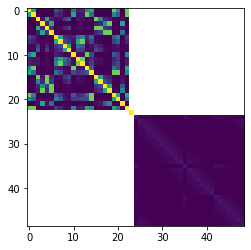

In [55]:
# build the prior; we are only doing this step to be able to look at this cool covariance matrix
# you could also record this to an external file if you really wanted to, but it is pretty huge due to the number of parameters
cov = pf.build_prior(fmt='none')

# and take a peak at a slice of the matrix
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [56]:
pe = pf.draw(num_reals=100,use_specsim=True)# draw pars from the prior
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-03-01 12:45:11.960204 starting: drawing realizations
2022-03-01 12:45:12.095807 starting: spectral simulation for grid-scale pars


SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.305006 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.359787 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.054781
2022-03-01 12:45:12.363724 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72


2022-03-01 12:45:12.410599 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046875
2022-03-01 12:45:12.415586 starting: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.462460 finished: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046874
2022-03-01 12:45:12.466449 starting: SpecSim: drawing 100 realization for group npf_k33_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.513349 finished: SpecSim: drawing 100 realization for group npf_k33_layer1_gr with 706 pars, (log) variance 0.0542

2022-03-01 12:45:12.615052 finished: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046874
2022-03-01 12:45:12.619042 starting: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.665917 finished: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046875
2022-03-01 12:45:12.669930 starting: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.716800 finished: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.05

2022-03-01 12:45:12.830476 starting: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.877206 finished: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046730
2022-03-01 12:45:12.881195 starting: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:12.929067 finished: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047872
2022-03-01 12:45:12.933058 starting: SpecSim: drawing 100 realization for group rch_recharge_12_gr with 706 pars, (log) vari

2022-03-01 12:45:13.034435 finished: SpecSim: drawing 100 realization for group rch_recharge_13_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047872
2022-03-01 12:45:13.038456 starting: SpecSim: drawing 100 realization for group rch_recharge_14_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.086296 finished: SpecSim: drawing 100 realization for group rch_recharge_14_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047840
2022-03-01 12:45:13.090286 starting: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.137160 finished: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) vari

2022-03-01 12:45:13.245931 starting: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.297462 finished: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.051531
2022-03-01 12:45:13.301455 starting: SpecSim: drawing 100 realization for group rch_recharge_19_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.350296 finished: SpecSim: drawing 100 realization for group rch_recharge_19_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.048841
2022-03-01 12:45:13.354286 starting: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) varia

2022-03-01 12:45:13.458548 starting: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.507002 finished: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.048454
2022-03-01 12:45:13.511023 starting: SpecSim: drawing 100 realization for group rch_recharge_22_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.558863 finished: SpecSim: drawing 100 realization for group rch_recharge_22_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047840
2022-03-01 12:45:13.563883 starting: SpecSim: drawing 100 realization for group rch_recharge_23_gr with 706 pars, (log) vari

2022-03-01 12:45:13.667618 starting: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.715490 finished: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047872
2022-03-01 12:45:13.719480 starting: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.766354 finished: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046874
2022-03-01 12:45:13.771341 starting: SpecSim: drawing 100 realization for group rch_recharge_4_gr with 706 pars, (log) varianc

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.919944 finished: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047837
2022-03-01 12:45:13.923933 starting: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:13.969810 finished: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045877
2022-03-01 12:45:13.973801 starting: SpecSim: drawing 100 realization for group rch_recharge_8_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:14.019677 finished: SpecSim: drawing 100 realizati

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-01 12:45:14.272002 finished: spectral simulation for grid-scale pars took: 0:00:02.176195
2022-03-01 12:45:14.272002 starting: Drawing non-specsim pars
building diagonal cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf_k_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k33_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['sto_ss_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['sto_sy_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_10_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_11_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_12_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_13_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_14_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_15_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_16_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_17_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_18_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_19_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_20_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_21_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_22_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_23_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_24_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_25_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_4_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_5_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_6_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_7_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_8_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_9_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcond_gr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['wel_cst']


build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
working on pargroups ['sfr_gr']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbhead_gr']
build cov matrix


done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


adding remaining parameters to diagonal


2022-03-01 12:45:22.200473 finished: Drawing non-specsim pars took: 0:00:07.928471


2022-03-01 12:45:24.346028 finished: drawing realizations took: 0:00:12.385824


noptmax:0, npar_adj:25454, nnz_obs:920
